### Import the standard libraries

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from shapely import wkt
from pathlib import Path
from autogluon.tabular import TabularDataset, TabularPredictor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option('display.max_columns', None)

In [59]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

### Pre-Process the Data

In [181]:
crs = "EPSG:25832"
root = Path("./data")
out = Path("./data/0_processed_data/master_merged.csv")
os.makedirs(root / "0_processed_data", exist_ok=True)

def safe_wkt_load(val):
    try:
        return wkt.loads(val)
    except Exception:
        return None

def read_solar_shapefiles(root: Path, crs: str) -> gpd.GeoDataFrame:
    solar_dirs = [
        f"{root}/8311_Solarpotenzial_Dachseiten_Freiburg_Stadt/Solarpotenziale_Dachseiten_Freiburg_Stadt.shp",
        f"{root}/8315_Solarpotenzial_Dachseiten_Breisgau_Hochschwarzwald/Solarpotenziale_Dachseiten_LK_Breisgau_Hochschwarzwald.shp",
        f"{root}/8316_Solarpotenzial_Dachseiten_Emmendingen/Solarpotenziale_Dachseiten_LK_Emmendingen.shp",
        f"{root}/8337_Solarpotenzial_Dachseiten_Waldshut/Solarpotenziale_Dachseiten_LK_Waldshut.shp",
    ]
    frames = [gpd.read_file(shp).to_crs(crs) for shp in solar_dirs]
    return pd.concat(frames, ignore_index=True)

def load_nexiga_data(root: Path, crs: str) -> gpd.GeoDataFrame:
    return gpd.read_file(root).to_crs(crs)

def load_existing_pv_data(root: Path, crs: str) -> gpd.GeoDataFrame:
    df = pd.read_csv(root, on_bad_lines="skip", sep=";", encoding='ISO-8859-1')
    df = df.rename(columns={"B Position": "geometry"})
    df = df[df["geometry"].notna()]
    df["geometry"] = df["geometry"].apply(safe_wkt_load)
    gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=crs)
    return gdf

def load_lv_connections(shp: Path, xlsx: Path, crs: str) -> gpd.GeoDataFrame:
    gdf = gpd.read_file(shp).to_crs(crs)
    gdf = gdf.rename(columns={"ID": "lv_id", "NS_HAUSANS": "connection_key"})
    meta = pd.read_excel(xlsx, sheet_name="Tabelle1").rename(
        columns={"NS-Hausanschluss": "connection_key"}
    )
    return gdf.merge(meta, on="connection_key", how="left")[
        ["lv_id", "connection_key", "Anschlusstyp", "Status", "geometry"]
    ]

def load_mv_lines(over_head: Path, cable: Path, crs: str) -> gpd.GeoDataFrame:
    over = gpd.read_file(over_head).to_crs(crs)
    cabl = gpd.read_file(cable).to_crs(crs)
    return pd.concat([over, cabl], ignore_index=True)[["ID", "geometry"]].rename(
        columns={"ID": "mv_line_id"}
    )

def load_stations(xlsx: Path, crs: str) -> gpd.GeoDataFrame:
    df = pd.read_excel(xlsx, sheet_name="Tabelle1")

    def to_point(s):
        if isinstance(s, str) and "," in s and "POINT" not in s.upper():
            lat, lon = map(float, s.split(","))
            return Point(lon, lat)

    df["geometry"] = df["Standort"].apply(to_point)
    return (
        gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
        .to_crs(crs)[["Id", "geometry"]]
        .rename(columns={"Id": "station_id"})
        .dropna(subset=["geometry"])
    )

def spatial_join_nearest(left, right, right_label, max_dist):
    j = gpd.sjoin_nearest(
        left[["geometry"]], right, how="left", max_distance=max_dist, distance_col="d"
    ).reset_index(drop=True)
    return j[right_label].where(j["d"].notna())

def build_master(nexiga_max_dist, existing_pv_max_dist):
    print("➜  solar potential …")
    roofs = read_solar_shapefiles(
        root / "Daten Hackaton (ALKIS,Nexiga,PV,HK)/Datenquellen/Solarpotenzial", crs
    )

    print("➜  nexiga data …")
    nexiga = load_nexiga_data(
        root / "Daten Hackaton (ALKIS,Nexiga,PV,HK)/Datenquellen/Nexiga Daten/nexiga_all.shp", crs
    )
    roofs = gpd.sjoin_nearest(
        roofs, nexiga, how="left", max_distance=nexiga_max_dist, distance_col="d"
    ).reset_index(drop=True)
    
    print("➜  existing pv …")
    existing_pv = load_existing_pv_data(
        root / "Strom-Einspeiser-Export 1.csv", "EPSG:4326"
    )
    if "index_right" in roofs.columns:
        roofs = roofs.drop(columns=["index_right"])
    roofs = roofs.to_crs(epsg=25832)
    existing_pv = existing_pv.to_crs(roofs.crs)
    roofs = gpd.sjoin_nearest(
        roofs, existing_pv, how="left", max_distance=existing_pv_max_dist, distance_col="d"
    ).reset_index(drop=True)
    
    # LV / MV infra
    lv = load_lv_connections(
        root / "Strom ST NS-HA-Kasten BP Position.shp",
        root / "Hausanschlüsse an der Niederspannung 1.xlsx",
        crs,
    )
    mv = load_mv_lines(
        root / "Strom ST MS-Freileitungsabschnitt BP Position.shp",
        root / "Strom ST MS-Kabelabschnitt BP Position.shp",
        crs,
    )
    stations = load_stations(root / "20250221_ST_Stationen 1.xlsx", crs)

    print("➜  nearest LV / MV / station …")
    roofs["lv_id"] = spatial_join_nearest(roofs, lv, "lv_id", 50)  # max_dist is in meter due to the crs being used
    roofs["mv_line_id"] = spatial_join_nearest(roofs, mv, "mv_line_id", 250)
    roofs["station_id"] = spatial_join_nearest(roofs, stations, "station_id", 500)

    roofs["centroid_x"] = roofs.geometry.centroid.x
    roofs["centroid_y"] = roofs.geometry.centroid.y
    roofs = roofs.rename(
        columns={"Power": "potential_kwp", "PvArea": "pv_area_m2", "Eignung": "suitability"}
    )

    roofs["connection_type"] = roofs["potential_kwp"].apply(
        lambda k: "LV" if k < 30 else ("MV" if k >= 30 else "Uncertain")
    )
    roofs["final_connection_id"] = roofs.apply(
        lambda r: r["lv_id"] if r["connection_type"] == "LV" else (r["station_id"] or r["mv_line_id"])
        if r["connection_type"] == "MV"
        else None,
        axis=1,
    )
    roofs["is_connectable"] = roofs["final_connection_id"].notnull()

    print(f"➜  writing {out} …")
    roofs.to_csv(out, index=False)
    print("✓  master dataframe created")
    return roofs, nexiga, existing_pv

In [182]:
# Load the Solarpotenzial + LV Connections + MV Lines data
roofs, nexiga, existing_pv = build_master(
    nexiga_max_dist = 100,
    existing_pv_max_dist = 100
)

➜  solar potential …
➜  nexiga data …
➜  existing pv …
➜  nearest LV / MV / station …
➜  writing data\0_processed_data\master_merged.csv …
✓  master dataframe created


In [183]:
roofs.shape

(762856, 107)

In [184]:
roofs.head(5)

,OBJECTID,BuildingID,RoofID,Slope,Aspect,RoofType,potential_kwp,suitability,Aufstd,Geplex_Dac,pv_area_m2,ErtKwP_K,ErtKwP_KA,ErtKwhaK,ErtKwhaKA,PercentMs,PercentMsA,Schatten,SchattenA,CO2Savings,Yield,ModuleCoun,Irradiatio,Area3D,GEMEINDE_N,LANGNAME,KREIS_NR,KREIS,ElevationS,JAHR,HERKUNFT,Shape_Leng,Shape_Area,geometry,_uid_,id,v_lfd,v_dat_adm,v_dat_post,kgs44,his,kgs36,kgs22,ags,kgs22_name,kgs8_name,plz,mplz,po_name,pot_name,str_name,hnr,hnr_zs,hnr_kompl,hnr_typ,lcew,lchh,kk_mio,kk_kat,dskz,kk_idx,lcgchar,lcbjkl,lcschicht,lcalter,lckumw,lckpre,lckneu,lcewb,lcewewa,lceemob,nx_x_etrsu,nx_y_etrsu,nx_kenn,d,index_right,Datenbestand,Tabelle,ID,Gemeinde,Straße,Hausnummer,Gewinnung,Betriebsspannung [kV],vereinbarte Anschlusswirkleistung [kW],(Peak-)Leistung [kW],Einbaudatum,Eigentum,Status,Bemerkung,NS Strecke,Station oder Maschennetz,Umspannwerke (versorgend),HS/MS-Trafos (versorgend),Abgänge (versorgend),Umspannwerke (anstehend),HS/MS-Trafos (anstehend),Abgänge (anstehend),Info zur Ermittlung,lv_id,mv_line_id,station_id,centroid_x,centroid_y,connection_type,final_connection_id,is_connectable
0,1,21581,0,8.08,330.88,Flachdach,3.920439,2,1,60.97,55.27,804.66,938.65,7412.68,3679.92,75.69,88.29,7.38,7.82,1398.3696,3679.92,12,1150.046994,61.581331,8311000.0,Freiburg im Breisgau,8311.0,"Freiburg im Breisgau, Stadt",2016-2021,2021,"LUBW, Geoplex GIS GmbH",31.412967,60.970800,"POLYGON ((404667.45 5320001.24, 404662.05 5320...",31175.0,92511.0,58.0,2101001,2103060,0831100079112004310067787010611123,4919158.0,08311000106111,08311000000176,08311000,Waltershofen 176,"Freiburg im Breisgau, Stadt",79112,79112000,Freiburg,Waltershofen,St.-Elisabethen-Str.,23.0,None,23,U,2.0,1.0,1.078845,5.0,0.0,102.958991,1.0,4.0,2.0,5.0,7.0,2.0,4.0,20000.0,70.0,9.0,404666.462,5320020.534,6.0,13.023546,11841.0,strom,ST NS-Einspeisung,112494271,Freiburg im Breisgau,St.-Elisabethen-Straße,17,Photovoltaik,"0,400000000","8,500","9,680",23.01.2024,NaN,in Betrieb,NaN,311N300,311S110,300W100 400W100,105,300W100(1.1.2) 300W100(1.2.6) 300W100(1.2.7) 3...,NaN,NaN,NaN,NaN,30502306.0,41826805.0,NaN,404667.490024,5.320007e+06,LV,30502306.0,True
1,2,69445,0,1.67,112.77,Flachdach,1.126032,3,1,17.76,8.26,796.63,846.61,1096.37,953.31,74.93,79.63,13.64,16.47,362.2578,953.31,3,1037.243653,17.767547,8311000.0,Freiburg im Breisgau,8311.0,"Freiburg im Breisgau, Stadt",2016-2021,2021,"LUBW, Geoplex GIS GmbH",17.885861,17.758600,"POLYGON ((404528.06 5320049.4, 404531.45 53200...",61752.0,92558.0,58.0,2101001,2103060,083110007911200431006768731002074,10443707.0,08311000100207,08311000000176,08311000,Waltershofen 176,"Freiburg im Breisgau, Stadt",79112,79112000,Freiburg,Waltershofen,Am Hohberg,4.0,None,4,G,2.0,1.0,1.106968,4.0,0.0,92.437513,1.0,3.0,1.0,3.0,6.0,5.0,4.0,20000.0,60.0,8.0,404547.289,5320035.615,6.0,17.463363,11860.0,strom,ST NS-Einspeisung,75376463,Freiburg im Breisgau,Am Hohberg,1a,Photovoltaik,"0,400000000","14,80","18,50",09.07.2021,NaN,in Betrieb,NaN,311N298,311S110,300W100 400W100,105,300W100(1.1.2) 300W100(1.2.6) 300W100(1.2.7) 3...,NaN,NaN,NaN,NaN,76360310.0,41826805.0,NaN,404528.530000,5.320046e+06,LV,76360310.0,True
2,3,186242,0,40.36,96.53,Spitzdach,0.000000,6,0,17.93,0.00,0.00,0.00,0.00,0.00,49.47,0.00,34.54,0.00,0.0000,0.00,0,644.385828,23.530474,8311000.0,Freiburg im Breisgau,8311.0,"Freiburg im Breisgau, Stadt",2016-2021,2021,"LUBW, Geoplex GIS GmbH",17.962544,17.926222,"POLYGON ((405310.81 5320640.89, 405310.24 5320...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3711405.0,NaN,405309.034990,5.320638e+06,LV,NaN,False
3,4,332960,0,35.00,140.42,Spitzdach,2.013977,1,0,11.63,12.08,1025.23,0.00,2064.79,0.00,96.43,0.00,0.00,0.00,784.6202,2064.79,6,1256.076924,14.197608,8311000.0,Freiburg im Breisgau,8311.0,"Freiburg im Breisgau, Stadt",2016-2021,2021,"

In [185]:
all_columns = roofs.columns

In [186]:
print(f"%age Historical Data Available - {100 * sum(roofs['Datenbestand'].value_counts()) / roofs.shape[0]:.2f}%")

%age Historical Data Available - 34.01%


In [187]:
all_historical_data = roofs.loc[roofs['Datenbestand'].notna()]
all_test_data = roofs.loc[roofs['Datenbestand'].isna()]
all_historical_data.to_csv("./data/0_processed_data/all_historical_data.csv")
all_test_data.to_csv("./data/0_processed_data/all_test_data.csv")

In [188]:
print(all_historical_data.shape)
print(all_test_data.shape)

(259450, 107)
(503406, 107)


In [189]:
for name in all_columns:
    print(name)

OBJECTID
BuildingID
RoofID
Slope
Aspect
RoofType
potential_kwp
suitability
Aufstd
Geplex_Dac
pv_area_m2
ErtKwP_K
ErtKwP_KA
ErtKwhaK
ErtKwhaKA
PercentMs
PercentMsA
Schatten
SchattenA
CO2Savings
Yield
ModuleCoun
Irradiatio
Area3D
GEMEINDE_N
LANGNAME
KREIS_NR
KREIS
ElevationS
JAHR
HERKUNFT
Shape_Leng
Shape_Area
geometry
_uid_
id
v_lfd
v_dat_adm
v_dat_post
kgs44
his
kgs36
kgs22
ags
kgs22_name
kgs8_name
plz
mplz
po_name
pot_name
str_name
hnr
hnr_zs
hnr_kompl
hnr_typ
lcew
lchh
kk_mio
kk_kat
dskz
kk_idx
lcgchar
lcbjkl
lcschicht
lcalter
lckumw
lckpre
lckneu
lcewb
lcewewa
lceemob
nx_x_etrsu
nx_y_etrsu
nx_kenn
d
index_right
Datenbestand
Tabelle
ID
Gemeinde
Straße
Hausnummer
Gewinnung
Betriebsspannung [kV]
vereinbarte Anschlusswirkleistung [kW]
(Peak-)Leistung [kW]
Einbaudatum
Eigentum
Status
Bemerkung
NS Strecke
Station oder Maschennetz
Umspannwerke (versorgend)
HS/MS-Trafos (versorgend)
Abgänge (versorgend)
Umspannwerke (anstehend)
HS/MS-Trafos (anstehend)
Abgänge (anstehend)
Info zur Ermittlun

In [190]:
all_historical_data.head()

,OBJECTID,BuildingID,RoofID,Slope,Aspect,RoofType,potential_kwp,suitability,Aufstd,Geplex_Dac,pv_area_m2,ErtKwP_K,ErtKwP_KA,ErtKwhaK,ErtKwhaKA,PercentMs,PercentMsA,Schatten,SchattenA,CO2Savings,Yield,ModuleCoun,Irradiatio,Area3D,GEMEINDE_N,LANGNAME,KREIS_NR,KREIS,ElevationS,JAHR,HERKUNFT,Shape_Leng,Shape_Area,geometry,_uid_,id,v_lfd,v_dat_adm,v_dat_post,kgs44,his,kgs36,kgs22,ags,kgs22_name,kgs8_name,plz,mplz,po_name,pot_name,str_name,hnr,hnr_zs,hnr_kompl,hnr_typ,lcew,lchh,kk_mio,kk_kat,dskz,kk_idx,lcgchar,lcbjkl,lcschicht,lcalter,lckumw,lckpre,lckneu,lcewb,lcewewa,lceemob,nx_x_etrsu,nx_y_etrsu,nx_kenn,d,index_right,Datenbestand,Tabelle,ID,Gemeinde,Straße,Hausnummer,Gewinnung,Betriebsspannung [kV],vereinbarte Anschlusswirkleistung [kW],(Peak-)Leistung [kW],Einbaudatum,Eigentum,Status,Bemerkung,NS Strecke,Station oder Maschennetz,Umspannwerke (versorgend),HS/MS-Trafos (versorgend),Abgänge (versorgend),Umspannwerke (anstehend),HS/MS-Trafos (anstehend),Abgänge (anstehend),Info zur Ermittlung,lv_id,mv_line_id,station_id,centroid_x,centroid_y,connection_type,final_connection_id,is_connectable
0,1,21581,0,8.08,330.88,Flachdach,3.920439,2,1,60.97,55.27,804.66,938.65,7412.68,3679.92,75.69,88.29,7.38,7.82,1398.3696,3679.92,12,1150.046994,61.581331,8311000.0,Freiburg im Breisgau,8311.0,"Freiburg im Breisgau, Stadt",2016-2021,2021,"LUBW, Geoplex GIS GmbH",31.412967,60.970800,"POLYGON ((404667.45 5320001.24, 404662.05 5320...",31175.0,92511.0,58.0,2101001,2103060,0831100079112004310067787010611123,4919158.0,08311000106111,08311000000176,08311000,Waltershofen 176,"Freiburg im Breisgau, Stadt",79112,79112000,Freiburg,Waltershofen,St.-Elisabethen-Str.,23.0,None,23,U,2.0,1.0,1.078845,5.0,0.0,102.958991,1.0,4.0,2.0,5.0,7.0,2.0,4.0,20000.0,70.0,9.0,404666.462,5320020.534,6.0,13.023546,11841.0,strom,ST NS-Einspeisung,112494271,Freiburg im Breisgau,St.-Elisabethen-Straße,17,Photovoltaik,"0,400000000","8,500","9,680",23.01.2024,NaN,in Betrieb,NaN,311N300,311S110,300W100 400W100,105,300W100(1.1.2) 300W100(1.2.6) 300W100(1.2.7) 3...,NaN,NaN,NaN,NaN,30502306.0,41826805.0,NaN,404667.490024,5.320007e+06,LV,30502306.0,True
1,2,69445,0,1.67,112.77,Flachdach,1.126032,3,1,17.76,8.26,796.63,846.61,1096.37,953.31,74.93,79.63,13.64,16.47,362.2578,953.31,3,1037.243653,17.767547,8311000.0,Freiburg im Breisgau,8311.0,"Freiburg im Breisgau, Stadt",2016-2021,2021,"LUBW, Geoplex GIS GmbH",17.885861,17.758600,"POLYGON ((404528.06 5320049.4, 404531.45 53200...",61752.0,92558.0,58.0,2101001,2103060,083110007911200431006768731002074,10443707.0,08311000100207,08311000000176,08311000,Waltershofen 176,"Freiburg im Breisgau, Stadt",79112,79112000,Freiburg,Waltershofen,Am Hohberg,4.0,None,4,G,2.0,1.0,1.106968,4.0,0.0,92.437513,1.0,3.0,1.0,3.0,6.0,5.0,4.0,20000.0,60.0,8.0,404547.289,5320035.615,6.0,17.463363,11860.0,strom,ST NS-Einspeisung,75376463,Freiburg im Breisgau,Am Hohberg,1a,Photovoltaik,"0,400000000","14,80","18,50",09.07.2021,NaN,in Betrieb,NaN,311N298,311S110,300W100 400W100,105,300W100(1.1.2) 300W100(1.2.6) 300W100(1.2.7) 3...,NaN,NaN,NaN,NaN,76360310.0,41826805.0,NaN,404528.530000,5.320046e+06,LV,76360310.0,True
5,6,441028,0,0.53,318.50,Flachdach,1.670768,3,1,28.32,17.79,777.53,851.74,2305.84,1423.06,73.14,80.12,14.77,15.99,540.7628,1423.06,5,1043.626290,28.321212,8311000.0,Freiburg im Breisgau,8311.0,"Freiburg im Breisgau, Stadt",2016-2021,2021,"LUBW, Geoplex GIS GmbH",21.787853,28.318050,"POLYGON ((404788.6 5320048.15, 404783.54 53200...",37536.0,92931.0,58.0,2101001,2103060,083110007911200431006773871032155,5595183.0,08311000103215,08311000000177,08311000,Waltershofen 177,"Freiburg im Breisgau, Stadt",79112,79112007,Freiburg,Waltershofen,Im Wännele,5.0,None,5,U,2.0,1.0,0.683834,6.0,0.0,105.422052,1.0,4.0,2.0,6.0,7.0,1.0,2.0,20000.0,71.0,7.0,404768.221,5320042.613,6.0,31.787568,11845.0,strom,ST NS-Einspeisung,113478171,Freiburg im Breisgau,Im Wännele,9,Photovoltaik,"0,400000000","15,00","21,84",31.05.2024,NaN,in Betrieb,NaN,311N314,311S110,300W100 400W100,105,3

In [27]:
features_for_training = [
    "Slope",
    "Aspect",
    "RoofType",
    "potential_kwp",
    "suitability",
    "Aufstd",
    "Geplex_Dac",
    "pv_area_m2",
    "ErtKwP_K",
    "ErtKwP_KA",
    "ErtKwhaK",
    "ErtKwhaKA",
    "PercentMs",
    "PercentMsA",
    "Schatten",
    "SchattenA",
    "CO2Savings",
    "Yield",
    "ModuleCoun",
    "Irradiatio",
    "Area3D",
    "GEMEINDE_N",
    "KREIS",
    "LANGNAME",
    "Shape_Leng",
    "Shape_Area",
    "centroid_x",
    "centroid_y",
    "connection_type",
    "(Peak-)Leistung [kW]"
]

In [192]:
for field in features_for_training:
    print(f"{field} : {all_historical_data[field].nunique()}")

Slope : 8655
Aspect : 35862
RoofType : 3
potential_kwp : 162738
suitability : 6
Aufstd : 2
Geplex_Dac : 25268
pv_area_m2 : 23284
ErtKwP_K : 52849
ErtKwP_KA : 21458
ErtKwhaK : 207101
ErtKwhaKA : 43119
PercentMs : 8877
PercentMsA : 6512
Schatten : 7630
SchattenA : 7211
CO2Savings : 209225
Yield : 209225
ModuleCoun : 657
Irradiatio : 69525
Area3D : 253338
GEMEINDE_N : 38
KREIS : 4
LANGNAME : 38
Betriebsspannung [kV] : 3
vereinbarte Anschlusswirkleistung [kW] : 2693
centroid_x : 254576
centroid_y : 254573
connection_type : 2
(Peak-)Leistung [kW] : 2815


In [29]:
continuous_vars = [
    "Slope",
    "Aspect",
    "potential_kwp",
    "pv_area_m2",
    "ErtKwP_K",
    "ErtKwP_KA",
    "ErtKwhaK",
    "ErtKwhaKA",
    "PercentMs",
    "PercentMsA",
    "Schatten",
    "SchattenA",
    "CO2Savings",
    "Yield",
    "ModuleCoun",
    "Irradiatio",
    "Area3D",
    "Geplex_Dac",
    "Shape_Leng",
    "Shape_Area",
    "centroid_x",
    "centroid_y"
]

discrete_vars = [
    "RoofType",
    "suitability",
    "Aufstd",
    "JAHR",
    "HERKUNFT",
    "GEMEINDE_N",
    "KREIS",
    "LANGNAME",
    "connection_type",
]

target_col = "(Peak-)Leistung [kW]"

In [194]:
all_historical_data[features_for_training].dtypes

Slope                                     float64
Aspect                                    float64
RoofType                                   object
potential_kwp                             float64
suitability                                 int64
Aufstd                                      int32
Geplex_Dac                                float64
pv_area_m2                                float64
ErtKwP_K                                  float64
ErtKwP_KA                                 float64
ErtKwhaK                                  float64
ErtKwhaKA                                 float64
PercentMs                                 float64
PercentMsA                                float64
Schatten                                  float64
SchattenA                                 float64
CO2Savings                                float64
Yield                                     float64
ModuleCoun                                  int64
Irradiatio                                float64


In [195]:
all_historical_data[features_for_training].head()

,Slope,Aspect,RoofType,potential_kwp,suitability,Aufstd,Geplex_Dac,pv_area_m2,ErtKwP_K,ErtKwP_KA,ErtKwhaK,ErtKwhaKA,PercentMs,PercentMsA,Schatten,SchattenA,CO2Savings,Yield,ModuleCoun,Irradiatio,Area3D,GEMEINDE_N,KREIS,LANGNAME,Betriebsspannung [kV],vereinbarte Anschlusswirkleistung [kW],centroid_x,centroid_y,connection_type,(Peak-)Leistung [kW]
0,8.08,330.88,Flachdach,3.920439,2,1,60.97,55.27,804.66,938.65,7412.68,3679.92,75.69,88.29,7.38,7.82,1398.3696,3679.92,12,1150.046994,61.581331,8311000.0,"Freiburg im Breisgau, Stadt",Freiburg im Breisgau,"0,400000000","8,500",404667.490024,5.320007e+06,LV,"9,680"
1,1.67,112.77,Flachdach,1.126032,3,1,17.76,8.26,796.63,846.61,1096.37,953.31,74.93,79.63,13.64,16.47,362.2578,953.31,3,1037.243653,17.767547,8311000.0,"Freiburg im Breisgau, Stadt",Freiburg im Breisgau,"0,400000000","14,80",404528.530000,5.320046e+06,LV,"18,50"
5,0.53,318.50,Flachdach,1.670768,3,1,28.32,17.79,777.53,851.74,2305.84,1423.06,73.14,80.12,14.77,15.99,540.7628,1423.06,5,1043.626290,28.321212,8311000.0,"Freiburg im Breisgau, Stadt",Freiburg im Breisgau,"0,400000000","15,00",404784.682140,5.320048e+06,LV,"21,84"
6,18.72,126.05,Spitzdach,6.157379,2,0,39.67,36.94,948.73,0.00,5841.69,0.00,89.24,0.00,3.79,6.99,2219.8422,5841.69,19,1162.421494,41.885831,8311000.0,"Freiburg im Breisgau, Stadt",Freiburg im Breisgau,"0,400000000","2,688",404742.864331,5.320004e+06,LV,"3,360"
7,19.84,319.69,Spitzdach,1.925627,3,0,30.33,11.55,791.55,0.00,1524.23,0.00,74.46,0.00,1.59,7.96,579.2074,1524.23,6,969.900319,32.243865,8311000.0,"Freiburg im Breisgau, Stadt",Freiburg im Breisgau,"0,400000000","5,650",404739.221271,5.320008e+06,LV,"7,062"


In [196]:
all_historical_data['(Peak-)Leistung [kW]'] = all_historical_data["(Peak-)Leistung [kW]"].str.replace(",", ".").astype(float)
all_historical_data['vereinbarte Anschlusswirkleistung [kW]'] = all_historical_data["vereinbarte Anschlusswirkleistung [kW]"].str.replace(",", ".").astype(float)

D:\conda_files\envs\bfhack\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
D:\conda_files\envs\bfhack\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [197]:
all_historical_data[features_for_training].dtypes

Slope                                     float64
Aspect                                    float64
RoofType                                   object
potential_kwp                             float64
suitability                                 int64
Aufstd                                      int32
Geplex_Dac                                float64
pv_area_m2                                float64
ErtKwP_K                                  float64
ErtKwP_KA                                 float64
ErtKwhaK                                  float64
ErtKwhaKA                                 float64
PercentMs                                 float64
PercentMsA                                float64
Schatten                                  float64
SchattenA                                 float64
CO2Savings                                float64
Yield                                     float64
ModuleCoun                                  int64
Irradiatio                                float64


### Split the historical data into train, validation and test

In [210]:
def split_data(df, target_col, seed=42):
    # Shuffle the full dataset
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

    # First split: 80% train, 20% temp
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=seed)

    # Second split: split temp into 50% val, 50% test → each is 10% of the original
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=seed)
    
    return train_df, val_df, test_df

train, val, test = split_data(all_historical_data, target_col=target_col)
train.to_csv("./data/0_processed_data/train.csv", index=False)
val.to_csv("./data/0_processed_data/val.csv", index=False)
test.to_csv("./data/0_processed_data/test.csv", index=False)

In [30]:
train = pd.read_csv("./data/0_processed_data/train.csv")
val = pd.read_csv("./data/0_processed_data/val.csv")
test = pd.read_csv("./data/0_processed_data/test.csv")
all_test_data = pd.read_csv("./data/0_processed_data/all_test_data.csv")

C:\Users\indra\AppData\Local\Temp\ipykernel_23044\2030246416.py:4: DtypeWarning: Columns (40,45,46,49,50,51,53,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  all_test_data = pd.read_csv("./data/0_processed_data/all_test_data.csv")


In [121]:
print(train.shape)
print(val.shape)
print(test.shape)

(207560, 134)
(25945, 134)
(25945, 134)


In [122]:
all_test_data.shape

(503406, 136)

In [31]:
train[target_col].head()

0     5.28
1     5.63
2     8.40
3    23.23
4     9.10
Name: (Peak-)Leistung [kW], dtype: float64

### Basic feature engineering - Min-Max Scaling for Continuous and Mean Encoding for Discrete/Categorical Variables

In [32]:
def normalize_continuous_features(train, val, test, all_test_data, continuous_cols, target_col=None):
    # Calculate min and max from training set only
    min_vals = train[continuous_cols].min()
    max_vals = train[continuous_cols].max()
    range_vals = max_vals - min_vals

    # Avoid division by zero (in case of constant columns)
    range_vals[range_vals == 0] = 1

    # Apply scaling
    for df in [train, val, test, all_test_data]:
        df[continuous_cols] = (df[continuous_cols] - min_vals) / range_vals

    return train, val, test, all_test_data


def encode_categorical_with_target_stats(train, val, test, all_test_data, categorical_cols, target_col, save_path="./data/0_processed_data/encoding_dfs"):
    os.makedirs(save_path, exist_ok=True)
    
    for col in categorical_cols:
        # Compute stats on training data
        agg = train.groupby(col)[target_col].agg(['mean', 'min', 'max']).rename(
            columns={"mean": f"{col}_mean", "min": f"{col}_min", "max": f"{col}_max"}
        )

        # Save encoding to CSV
        agg.reset_index().to_csv(f"{save_path}/{col}_encoding.csv", index=False)

        # Map to datasets
        for df in [train, val, test, all_test_data]:
            df[f"{col}_mean"] = df[col].map(agg[f"{col}_mean"])
            df[f"{col}_min"] = df[col].map(agg[f"{col}_min"])
            df[f"{col}_max"] = df[col].map(agg[f"{col}_max"])

    return train, val, test, all_test_data

In [33]:
train, val, test, all_test_data = normalize_continuous_features(train, val, test, all_test_data, continuous_vars)

In [34]:
train, val, test, all_test_data = encode_categorical_with_target_stats(
    train, val, test, all_test_data,
    categorical_cols=discrete_vars,
    target_col=target_col,
)

In [35]:
train.head()

,OBJECTID,BuildingID,RoofID,Slope,Aspect,RoofType,potential_kwp,suitability,Aufstd,Geplex_Dac,pv_area_m2,ErtKwP_K,ErtKwP_KA,ErtKwhaK,ErtKwhaKA,PercentMs,PercentMsA,Schatten,SchattenA,CO2Savings,Yield,ModuleCoun,Irradiatio,Area3D,GEMEINDE_N,LANGNAME,KREIS_NR,KREIS,ElevationS,JAHR,HERKUNFT,Shape_Leng,Shape_Area,geometry,_uid_,id,v_lfd,v_dat_adm,v_dat_post,kgs44,his,kgs36,kgs22,ags,kgs22_name,kgs8_name,plz,mplz,po_name,pot_name,str_name,hnr,hnr_zs,hnr_kompl,hnr_typ,lcew,lchh,kk_mio,kk_kat,dskz,kk_idx,lcgchar,lcbjkl,lcschicht,lcalter,lckumw,lckpre,lckneu,lcewb,lcewewa,lceemob,nx_x_etrsu,nx_y_etrsu,nx_kenn,d,index_right,Datenbestand,Tabelle,ID,Gemeinde,Straße,Hausnummer,Gewinnung,Betriebsspannung [kV],vereinbarte Anschlusswirkleistung [kW],(Peak-)Leistung [kW],Einbaudatum,Eigentum,Status,Bemerkung,NS Strecke,Station oder Maschennetz,Umspannwerke (versorgend),HS/MS-Trafos (versorgend),Abgänge (versorgend),Umspannwerke (anstehend),HS/MS-Trafos (anstehend),Abgänge (anstehend),Info zur Ermittlung,lv_id,mv_line_id,station_id,centroid_x,centroid_y,connection_type,final_connection_id,is_connectable,RoofType_mean,RoofType_min,RoofType_max,suitability_mean,suitability_min,suitability_max,Aufstd_mean,Aufstd_min,Aufstd_max,JAHR_mean,JAHR_min,JAHR_max,HERKUNFT_mean,HERKUNFT_min,HERKUNFT_max,GEMEINDE_N_mean,GEMEINDE_N_min,GEMEINDE_N_max,KREIS_mean,KREIS_min,KREIS_max,LANGNAME_mean,LANGNAME_min,LANGNAME_max,connection_type_mean,connection_type_min,connection_type_max
0,14293,1961807,1,0.457143,0.434488,Spitzdach,0.004620,1,0,0.001859,6.862219e-14,0.967784,0.0,8.615449e-12,0.0,0.9773,0.0,0.003314,0.0,8.615449e-12,8.615449e-12,0.004603,0.975452,1.101433e-16,8315059.0,Ihringen,8315.0,Breisgau-Hochschwarzwald,2016-2021,2021,"LUBW, Geoplex GIS GmbH",0.016217,0.001859,"POLYGON ((399076.2400000002 5322188.59, 399074...",6116.0,48332.0,58.0,2101001.0,2103060.0,0831505979241007328067994900000814,10645831.0,8.315059e+12,8.315059e+12,8315059.0,Ihringen 402,Ihringen,79241.0,79241007.0,Ihringen,Ihringen,Bachenstr.,14.0,NaN,14,G,2.0,1.0,4.327120,6.0,0.0,107.727699,2.0,1.0,3.0,4.0,9.0,2.0,1.0,17000.0,56.0,2.0,399079.655,5322200.249,6.0,18.746936,2932.0,strom,ST NS-Einspeisung,109285067,Ihringen,Vogelgasse,8,Photovoltaik,"0,400000000",4.600,5.28,08.03.2022,NaN,in Betrieb,NaN,842F380,842S070,800W100,801,800W100(2.1.2) 800W100(2.1.4),NaN,NaN,NaN,NaN,13983885.0,15361997.0,NaN,0.137900,0.732954,LV,13983885.0,True,21.646722,0.042,62000.0,43.100407,0.042,62000.0,23.578682,0.042,62000.0,38.746186,0.042,62000.0,38.746186,0.042,62000.0,13.191165,0.600,446.4,17.582507,0.042,20000.0,13.191165,0.600,446.4,35.855863,0.042,62000.0
1,256842,5779540,0,0.569011,0.044765,Spitzdach,0.000000,6,0,0.002701,1.849886e-14,0.504897,0.0,1.211982e-12,0.0,0.5103,0.0,0.000000,0.0,1.211982e-12,1.211982e-12,0.000000,0.501820,1.925409e-16,8315047.0,Gundelfingen,8315.0,Breisgau-Hochschwarzwald,2016-2021,2021,"LUBW, Geoplex GIS GmbH",0.019668,0.002701,"POLYGON ((415997.70999999996 5320340.65, 41600...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.602023,629.0,strom_andere,ST NS-Einspeisung,331349052,Gundelfingen,Vorstädtleweg,14+PV,Photovoltaik,"0,400000000",4.504,5.63,30.01.2013,(fremd) fremd,in Betrieb,NaN,531N022,531S120,NaN,NaN,NaN,NaN,NaN,NaN,:netzname_ambiguous,NaN,NaN,NaN,0.402610,0.705456,LV,NaN,False,21.646722,0.042,62000.0,42.162251,0.042,62000.0,23.578682,0.042,62000.0,38.746186,0.042,62000.0,38.746186,0.042,62000.0,12.741311,0.042,1800.0,17.582507,0.042,20000.0,12.741311,0.042,1800.0,35.855863,0.042,62000.0
2,40136,3309674,0,0.506374,0.052798,Spitzdach,0.000000,6,0,0.004596,1.550473e-14,0.531723,0.0,1.069182e-12,0.0,0.5576,0.0,0.000000,0.0,1.069182e-12,1.069182e-12,0.000000,0.531760,2.917960e-16,8311000.0,Freiburg im Breisgau,8311.0,"Freiburg im Breisgau, Stadt",2016-2021,2021,"LUBW, Geoplex GIS GmbH",0.024968,0.004596,"POLYGON ((415288.1799999997 5317676.119999999,...

In [36]:
train.fillna(0.0, inplace=True)
val.fillna(0.0, inplace=True)
test.fillna(0.0, inplace=True)
all_test_data.fillna(0.0, inplace=True)

### Do Classical ML

In [37]:
encoded_discrete_features = [
    f"{col}_{stat}" for col in discrete_vars for stat in ["mean", "min", "max"]
]

final_features = continuous_vars + encoded_discrete_features

In [39]:
print(final_features)
print(len(final_features))

['Slope', 'Aspect', 'potential_kwp', 'pv_area_m2', 'ErtKwP_K', 'ErtKwP_KA', 'ErtKwhaK', 'ErtKwhaKA', 'PercentMs', 'PercentMsA', 'Schatten', 'SchattenA', 'CO2Savings', 'Yield', 'ModuleCoun', 'Irradiatio', 'Area3D', 'Geplex_Dac', 'Shape_Leng', 'Shape_Area', 'centroid_x', 'centroid_y', 'RoofType_mean', 'RoofType_min', 'RoofType_max', 'suitability_mean', 'suitability_min', 'suitability_max', 'Aufstd_mean', 'Aufstd_min', 'Aufstd_max', 'JAHR_mean', 'JAHR_min', 'JAHR_max', 'HERKUNFT_mean', 'HERKUNFT_min', 'HERKUNFT_max', 'GEMEINDE_N_mean', 'GEMEINDE_N_min', 'GEMEINDE_N_max', 'KREIS_mean', 'KREIS_min', 'KREIS_max', 'LANGNAME_mean', 'LANGNAME_min', 'LANGNAME_max', 'connection_type_mean', 'connection_type_min', 'connection_type_max']
49


In [40]:
results = []

In [52]:
def evaluate_model(name, model, train, val, test, features, target):
    print(f"Training - {name}")
    model.fit(train[features], train[target])
    val_preds = model.predict(val[features])
    test_preds = model.predict(test[features])
    results.append({
        "Model": name,
        "Val MAE": mean_absolute_error(val[target], val_preds),
        "Val MSE": mean_squared_error(val[target], val_preds),
        "Test MAE": mean_absolute_error(test[target], test_preds),
        "Test MSE": mean_squared_error(test[target], test_preds)
    })
    if hasattr(model, "feature_importances_"):
        importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
        print(f"Feature Importances ({name}):\n{importances}")
        return importances
    elif name == "Linear Regression":
        if hasattr(model, "coef_"):
            importances = pd.Series(model.coef_, index=features).sort_values(key=abs, ascending=False)
            print(f"Coefficients ({name}):\n{importances}")
            return importances
    else:
        print(f"{name} does not support feature importances.")
        return None

In [42]:
# Linear Regression
lr = LinearRegression()
lr_importances = evaluate_model("Linear Regression", lr, train, val, test, final_features, target_col)

Training - Linear Regression
Coefficients (Linear Regression):
potential_kwp          -2.783956e+04
ModuleCoun              2.259859e+04
Shape_Leng              1.970996e+03
Geplex_Dac              1.937184e+03
Shape_Area              1.936776e+03
ErtKwhaKA              -7.832359e+02
suitability_min        -6.172666e+02
PercentMsA              3.995014e+02
PercentMs               2.706678e+02
Irradiatio             -2.103419e+02
KREIS_min              -2.045439e+02
Schatten                1.926677e+02
SchattenA               1.642257e+02
Area3D                 -1.270886e+02
ErtKwP_KA              -1.182258e+02
centroid_y              9.238086e+01
Slope                   9.198494e+01
pv_area_m2              7.572670e+01
ErtKwP_K                2.515107e+01
centroid_x             -2.128917e+01
Aspect                  1.803238e+01
ErtKwhaK               -8.472724e+00
Yield                  -8.472657e+00
CO2Savings             -8.472657e+00
KREIS_mean              8.076962e+00
Aufstd_mean 

In [44]:
# KNN Regressor
knn = KNeighborsRegressor()
evaluate_model("KNN Regressor", knn, train, val, test, final_features, target_col)

Training - KNN Regressor
KNN Regressor does not support feature importances.


In [45]:
# Decision Tree
dt = DecisionTreeRegressor()
dt_importances = evaluate_model("Decision Tree", dt, train, val, test, final_features, target_col)

Training - Decision Tree
Feature Importances (Decision Tree):
centroid_x              6.982364e-01
SchattenA               8.947734e-02
centroid_y              6.097046e-02
Shape_Area              3.912825e-02
Slope                   3.781855e-02
ErtKwP_KA               2.318962e-02
PercentMsA              2.179535e-02
GEMEINDE_N_mean         1.297340e-02
PercentMs               1.287722e-02
LANGNAME_mean           1.802341e-03
Shape_Leng              6.035902e-04
Geplex_Dac              3.082607e-04
Area3D                  2.222768e-04
pv_area_m2              1.968591e-04
Irradiatio              7.532688e-05
ErtKwhaK                7.068283e-05
Aspect                  5.761264e-05
ErtKwP_K                4.534451e-05
Yield                   2.858062e-05
Schatten                2.585584e-05
ErtKwhaKA               2.062524e-05
CO2Savings              1.555875e-05
GEMEINDE_N_min          1.520555e-05
potential_kwp           1.187288e-05
LANGNAME_min            9.781773e-06
suitability_m

In [46]:
# Random Forest
rf = RandomForestRegressor()
rf_importances = evaluate_model("Random Forest", rf, train, val, test, final_features, target_col)

Training - Random Forest
Feature Importances (Random Forest):
centroid_x              5.150179e-01
centroid_y              9.604996e-02
Slope                   8.205753e-02
SchattenA               4.888845e-02
Shape_Leng              3.883354e-02
Schatten                3.469157e-02
Aspect                  3.079325e-02
Shape_Area              2.572503e-02
Geplex_Dac              2.131421e-02
PercentMsA              1.945972e-02
Area3D                  1.248737e-02
PercentMs               1.118570e-02
ErtKwhaKA               9.362925e-03
Irradiatio              8.847257e-03
ErtKwP_K                7.909423e-03
potential_kwp           6.755395e-03
pv_area_m2              4.953218e-03
ErtKwhaK                4.900889e-03
Yield                   3.545587e-03
ModuleCoun              3.044932e-03
CO2Savings              2.947811e-03
ErtKwP_KA               2.910297e-03
LANGNAME_mean           1.555378e-03
GEMEINDE_N_mean         1.473123e-03
Aufstd_mean             7.138529e-04
LANGNAME_max 

In [47]:
# AdaBoost
ada = AdaBoostRegressor()
ada_importances = evaluate_model("AdaBoost", ada, train, val, test, final_features, target_col)

Training - AdaBoost
Feature Importances (AdaBoost):
centroid_x              4.906401e-01
centroid_y              4.881191e-01
Schatten                8.627433e-03
potential_kwp           6.711053e-03
LANGNAME_mean           2.851047e-03
Shape_Leng              1.520160e-03
PercentMs               8.047356e-04
PercentMsA              6.981107e-04
GEMEINDE_N_mean         1.932851e-05
Geplex_Dac              5.501129e-06
LANGNAME_min            3.464236e-06
LANGNAME_max            4.470955e-08
Area3D                  1.147233e-08
Slope                   1.926488e-09
pv_area_m2              4.057833e-10
ErtKwhaKA               3.693646e-10
ErtKwP_KA               1.795456e-10
suitability_mean        2.912102e-21
ModuleCoun              0.000000e+00
Yield                   0.000000e+00
CO2Savings              0.000000e+00
SchattenA               0.000000e+00
Aspect                  0.000000e+00
ErtKwP_K                0.000000e+00
ErtKwhaK                0.000000e+00
Irradiatio             

In [48]:
# Gradient Boosting
gb = GradientBoostingRegressor()
gb_importances = evaluate_model("GradientBoost", gb, train, val, test, final_features, target_col)

Training - GradientBoost
Feature Importances (GradientBoost):
centroid_y              0.715781
centroid_x              0.222468
Shape_Area              0.013887
CO2Savings              0.005782
PercentMs               0.005494
Shape_Leng              0.004781
Area3D                  0.004549
pv_area_m2              0.004181
Schatten                0.003488
Geplex_Dac              0.003315
Aspect                  0.001875
ModuleCoun              0.001864
LANGNAME_mean           0.001850
Slope                   0.001651
SchattenA               0.001589
ErtKwhaKA               0.001527
Yield                   0.001411
GEMEINDE_N_mean         0.001183
ErtKwhaK                0.000960
Irradiatio              0.000618
ErtKwP_KA               0.000548
KREIS_mean              0.000508
PercentMsA              0.000428
GEMEINDE_N_max          0.000192
LANGNAME_min            0.000025
GEMEINDE_N_min          0.000018
LANGNAME_max            0.000014
potential_kwp           0.000010
ErtKwP_K      

In [53]:
# XGBoost
xgb = XGBRegressor(verbosity=0)
xgb_importances = evaluate_model("XGBoost", xgb, train, val, test, final_features, target_col)

Training - XGBoost
Feature Importances (XGBoost):
centroid_x              0.854635
Slope                   0.025343
potential_kwp           0.023835
centroid_y              0.021347
Schatten                0.017993
GEMEINDE_N_mean         0.010825
pv_area_m2              0.008424
ErtKwP_KA               0.006888
SchattenA               0.005438
Area3D                  0.005287
ErtKwP_K                0.003671
Aspect                  0.003517
ErtKwhaK                0.003477
Geplex_Dac              0.002602
Shape_Leng              0.002273
PercentMsA              0.001175
PercentMs               0.000920
ErtKwhaKA               0.000487
Shape_Area              0.000369
CO2Savings              0.000359
suitability_mean        0.000235
GEMEINDE_N_min          0.000201
ModuleCoun              0.000178
Irradiatio              0.000171
KREIS_min               0.000158
GEMEINDE_N_max          0.000100
KREIS_mean              0.000061
connection_type_mean    0.000026
RoofType_mean           0.

In [54]:
# LightGBM
lgbm = LGBMRegressor()
lgbm_importances = evaluate_model("LightGBM", lgbm, train, val, test, final_features, target_col)

Training - LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5857
[LightGBM] [Info] Number of data points in the train set: 207560, number of used features: 40
[LightGBM] [Info] Start training from score 38.745812
Feature Importances (LightGBM):
centroid_y              562
centroid_x              516
Slope                   167
Aspect                  150
Shape_Leng              147
SchattenA               145
GEMEINDE_N_mean         136
ModuleCoun              129
ErtKwP_KA               126
Schatten                121
PercentMsA              118
Area3D                  102
ErtKwhaKA                95
PercentMs                89
Geplex_Dac               84
Irradiatio               55
ErtKwP_K                 53
Shape_Area               47
GEMEINDE_N_min           40
potentia

In [55]:
results_df = pd.DataFrame(results)
print("\n📊 Model Performance Summary:")
print(results_df.sort_values("Val MAE"))


📊 Model Performance Summary:
               Model    Val MAE       Val MSE   Test MAE       Test MSE
6            XGBoost  17.333282  1.615730e+05  17.411370  153009.351114
2      Decision Tree  18.089847  4.505422e+05  17.179843  320122.103228
4           AdaBoost  21.133261  8.140000e+04  17.786058   43804.917303
7           LightGBM  24.830957  1.364936e+05  23.369403   97026.341376
3      Random Forest  33.595971  5.386310e+05  23.743863  322557.350688
5      GradientBoost  50.591488  6.486123e+05  43.309528  289950.216006
1      KNN Regressor  57.869517  1.903172e+06  40.281145  720429.454513
0  Linear Regression  75.868790  1.832146e+06  55.037572  509721.330718


### Now let's do HPO for XGBoost - AutoML Time!

In [57]:
important_features = [
    "centroid_x",
    "Slope",
    "potential_kwp",
    "centroid_y",
    "Schatten",
    "GEMEINDE_N_mean",
    "pv_area_m2",
    "ErtKwP_KA",
    "SchattenA",
    "Area3D",
    "ErtKwP_K",
    "Aspect",
    "ErtKwhaK",
    "Geplex_Dac",
    "Shape_Leng",
    "PercentMsA",
    "PercentMs",
    "ErtKwhaKA",
    "Shape_Area",
    "CO2Savings",
    "suitability_mean",
    "GEMEINDE_N_min",
    "ModuleCoun",
    "Irradiatio",
    "KREIS_min",
    "GEMEINDE_N_max",
    "KREIS_mean",
    "connection_type_mean",
    "RoofType_mean"
]

In [58]:
!pip install scikit-optimize


   ---------------------------------------- 0/2 [pyaml]
   ---------------------------------------- 0/2 [pyaml]
   ---------------------------------------- 0/2 [pyaml]
   ---------------------------------------- 0/2 [pyaml]
   ---------------------------------------- 0/2 [pyaml]
   ---------------------------------------- 0/2 [pyaml]
   ---------------------------------------- 0/2 [pyaml]
   ---------------------------------------- 0/2 [pyaml]
   -------------------- ------------------- 1/2 [scikit-optimize]
   -------------------- ------------------- 1/2 [scikit-optimize]
   -------------------- ------------------- 1/2 [scikit-optimize]
   -------------------- ------------------- 1/2 [scikit-optimize]
   ---------------------------------------- 2/2 [scikit-optimize]



In [60]:
search_spaces = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 15),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'gamma': Real(0, 5),
    'min_child_weight': Integer(1, 10),
    'reg_alpha': Real(0, 1.0),
    'reg_lambda': Real(0, 1.0)
}

In [61]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

In [63]:
opt = BayesSearchCV(
    estimator=xgb,
    search_spaces=search_spaces,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_iter=30,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [64]:
opt.fit(train[important_features], train[target_col])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0, high=1.0, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0, high=1.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')},
              verbose=2)

In [65]:
best_model = opt.best_estimator_
best_params = opt.best_params_
print("\nBest Parameters:\n", best_params)


Best Parameters:
 OrderedDict([('colsample_bytree', 1.0), ('gamma', 4.367714788614503), ('learning_rate', 0.011858770849610884), ('max_depth', 10), ('min_child_weight', 10), ('n_estimators', 478), ('reg_alpha', 0.0), ('reg_lambda', 0.9991633784444588), ('subsample', 0.9419998789881558)])


In [69]:
val_preds = best_model.predict(val[important_features])
test_preds = best_model.predict(test[important_features])
results.append({
    "Model": "Best XGB",
    "Val MAE": mean_absolute_error(val[target_col], val_preds),
    "Val MSE": mean_squared_error(val[target_col], val_preds),
    "Test MAE": mean_absolute_error(test[target_col], test_preds),
    "Test MSE": mean_squared_error(test[target_col], test_preds)
})

In [70]:
results_df = pd.DataFrame(results)
print("\n📊 Model Performance Summary:")
print(results_df.sort_values("Val MAE"))


📊 Model Performance Summary:
               Model    Val MAE       Val MSE   Test MAE       Test MSE
6            XGBoost  17.333282  1.615730e+05  17.411370  153009.351114
2      Decision Tree  18.089847  4.505422e+05  17.179843  320122.103228
8           Best XGB  19.568833  1.797803e+05  19.501021  178074.701912
4           AdaBoost  21.133261  8.140000e+04  17.786058   43804.917303
7           LightGBM  24.830957  1.364936e+05  23.369403   97026.341376
3      Random Forest  33.595971  5.386310e+05  23.743863  322557.350688
5      GradientBoost  50.591488  6.486123e+05  43.309528  289950.216006
1      KNN Regressor  57.869517  1.903172e+06  40.281145  720429.454513
0  Linear Regression  75.868790  1.832146e+06  55.037572  509721.330718


### AutoML didn't help!

In [77]:
xgb = XGBRegressor(verbosity=0)
xgb.fit(train[final_features], train[target_col])
preds = xgb.predict(all_test_data[final_features])

In [78]:
preds

array([  87.914215,   85.73823 ,   85.22975 , ..., 1427.3589  ,
       1431.3943  , 1427.9727  ], dtype=float32)

In [111]:
all_test_data['XGB Preds'] = preds
all_test_data.loc[all_test_data['XGB Preds']<0] = 0

In [112]:
all_test_data.head()

,Unnamed: 0,OBJECTID,BuildingID,RoofID,Slope,Aspect,RoofType,potential_kwp,suitability,Aufstd,Geplex_Dac,pv_area_m2,ErtKwP_K,ErtKwP_KA,ErtKwhaK,ErtKwhaKA,PercentMs,PercentMsA,Schatten,SchattenA,CO2Savings,Yield,ModuleCoun,Irradiatio,Area3D,GEMEINDE_N,LANGNAME,KREIS_NR,KREIS,ElevationS,JAHR,HERKUNFT,Shape_Leng,Shape_Area,geometry,_uid_,id,v_lfd,v_dat_adm,v_dat_post,kgs44,his,kgs36,kgs22,ags,kgs22_name,kgs8_name,plz,mplz,po_name,pot_name,str_name,hnr,hnr_zs,hnr_kompl,hnr_typ,lcew,lchh,kk_mio,kk_kat,dskz,kk_idx,lcgchar,lcbjkl,lcschicht,lcalter,lckumw,lckpre,lckneu,lcewb,lcewewa,lceemob,nx_x_etrsu,nx_y_etrsu,nx_kenn,d,index_right,Datenbestand,Tabelle,ID,Gemeinde,Straße,Hausnummer,Gewinnung,Betriebsspannung [kV],vereinbarte Anschlusswirkleistung [kW],(Peak-)Leistung [kW],Einbaudatum,Eigentum,Status,Bemerkung,NS Strecke,Station oder Maschennetz,Umspannwerke (versorgend),HS/MS-Trafos (versorgend),Abgänge (versorgend),Umspannwerke (anstehend),HS/MS-Trafos (anstehend),Abgänge (anstehend),Info zur Ermittlung,lv_id,mv_line_id,station_id,centroid_x,centroid_y,connection_type,final_connection_id,is_connectable,RoofType_mean,RoofType_min,RoofType_max,suitability_mean,suitability_min,suitability_max,Aufstd_mean,Aufstd_min,Aufstd_max,JAHR_mean,JAHR_min,JAHR_max,HERKUNFT_mean,HERKUNFT_min,HERKUNFT_max,GEMEINDE_N_mean,GEMEINDE_N_min,GEMEINDE_N_max,KREIS_mean,KREIS_min,KREIS_max,LANGNAME_mean,LANGNAME_min,LANGNAME_max,connection_type_mean,connection_type_min,connection_type_max,XGB Preds
0,2,3,186242,0,0.454505,0.270166,Spitzdach,0.000000,6,0,0.000855,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.4947,0.000000,0.346822,0.000000,0.000000e+00,0.000000e+00,0.000000,0.494777,5.091897e-17,8311000.0,Freiburg im Breisgau,8311.0,"Freiburg im Breisgau, Stadt",2016-2021,2021,"LUBW, Geoplex GIS GmbH",0.009371,0.000855,"POLYGON ((405310.8099999996 5320640.890000001,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3711405.0,0.0,0.235339,0.709915,LV,0.0,False,21.646722,0.042,62000.0,42.162251,0.042,62000.0,23.578682,0.042,62000.0,38.746186,0.042,62000.0,38.746186,0.042,62000.0,73.7833,0.2,62000.0,73.7833,0.2,62000.0,73.7833,0.2,62000.0,35.855863,0.042,62000.0,87.914215
1,3,4,332960,0,0.395604,0.391745,Spitzdach,0.001317,1,0,0.000527,1.955085e-14,0.964641,0.000000,2.447517e-12,0.000000,0.9643,0.000000,0.000000,0.000000,2.447517e-12,2.447517e-12,0.001255,0.964450,2.918995e-17,8311000.0,Freiburg im Breisgau,8311.0,"Freiburg im Breisgau, Stadt",2016-2021,2021,"LUBW, Geoplex GIS GmbH",0.007621,0.000527,POLYGON ((404796.01109999977 5320891.754899999...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227359,0.713691,LV,0.0,False,21.646722,0.042,62000.0,43.100407,0.042,62000.0,23.578682,0.042,62000.0,38.746186,0.042,62000.0,38.746186,0.042,62000.0,73.7833,0.2,62000.0,73.7833,0.2,62000.0,73.7833,0.2,62000.0,35.855863,0.042,62000.0,85.738228
2,4,5,332960,1,0.422527,0.888006,Spitzdach,0.000000,6,0,0.000444,1.681567e-14,0.649091,0.000000,1.415828e-12,0.000000,0.6489,0.000000,0.000000,0.000000,1.415828e-12,1.415828e-12,0.000000,0.649001,2.560836e-17,8311000.0,Freiburg im Breisgau,8311.0,"Freiburg im Breisgau, Stadt",2016-2021,2021,"LUBW, Geoplex GIS GmbH",0.007232,0.000444,"POLYGON ((404799.36000000034 5320896.74, 40480...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227340,0.713712,LV,0.0,False,21.6

In [113]:
all_test_data[["geometry", "XGB Preds"]].to_csv("./data/0_processed_data/first_preds.csv", index=False)

In [114]:
all_test_data['KREIS'].unique()

array(['Freiburg im Breisgau, Stadt', 0, 'Breisgau-Hochschwarzwald',
       'Emmendingen', 'Waldshut'], dtype=object)

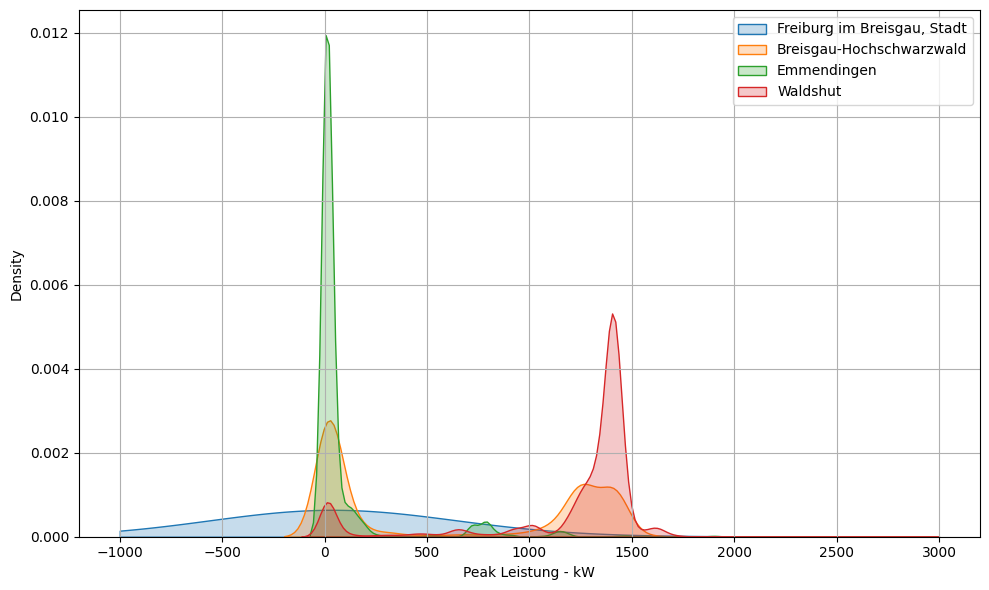

In [116]:
plt.figure(figsize=(10, 6))
sns.kdeplot(all_test_data.loc[all_test_data['KREIS'] == "Freiburg im Breisgau, Stadt", "XGB Preds"], label="Freiburg im Breisgau, Stadt", fill=True, clip=(-1000, 3000))
sns.kdeplot(all_test_data.loc[all_test_data['KREIS'] == "Breisgau-Hochschwarzwald", "XGB Preds"], label="Breisgau-Hochschwarzwald", fill=True, clip=(-1000, 3000))
sns.kdeplot(all_test_data.loc[all_test_data['KREIS'] == "Emmendingen", "XGB Preds"], label="Emmendingen", fill=True, clip=(-1000, 3000))
sns.kdeplot(all_test_data.loc[all_test_data['KREIS'] == "Waldshut", "XGB Preds"], label="Waldshut", fill=True, clip=(-1000, 3000))

plt.xlabel("Peak Leistung - kW")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [103]:
all_test_data.loc[all_test_data["XGB Preds"] >= 3000].shape

(242, 136)

In [105]:
all_test_data.loc[all_test_data["XGB Preds"] >= 3000, "KREIS"].value_counts()

KREIS
Freiburg im Breisgau, Stadt    148
Breisgau-Hochschwarzwald        78
Emmendingen                     13
Waldshut                         3
Name: count, dtype: int64

In [120]:
all_test_data.loc[(all_test_data["XGB Preds"] < 0) & (all_test_data["KREIS"] == "Freiburg im Breisgau, Stadt")].head()

,Unnamed: 0,OBJECTID,BuildingID,RoofID,Slope,Aspect,RoofType,potential_kwp,suitability,Aufstd,Geplex_Dac,pv_area_m2,ErtKwP_K,ErtKwP_KA,ErtKwhaK,ErtKwhaKA,PercentMs,PercentMsA,Schatten,SchattenA,CO2Savings,Yield,ModuleCoun,Irradiatio,Area3D,GEMEINDE_N,LANGNAME,KREIS_NR,KREIS,ElevationS,JAHR,HERKUNFT,Shape_Leng,Shape_Area,geometry,_uid_,id,v_lfd,v_dat_adm,v_dat_post,kgs44,his,kgs36,kgs22,ags,kgs22_name,kgs8_name,plz,mplz,po_name,pot_name,str_name,hnr,hnr_zs,hnr_kompl,hnr_typ,lcew,lchh,kk_mio,kk_kat,dskz,kk_idx,lcgchar,lcbjkl,lcschicht,lcalter,lckumw,lckpre,lckneu,lcewb,lcewewa,lceemob,nx_x_etrsu,nx_y_etrsu,nx_kenn,d,index_right,Datenbestand,Tabelle,ID,Gemeinde,Straße,Hausnummer,Gewinnung,Betriebsspannung [kV],vereinbarte Anschlusswirkleistung [kW],(Peak-)Leistung [kW],Einbaudatum,Eigentum,Status,Bemerkung,NS Strecke,Station oder Maschennetz,Umspannwerke (versorgend),HS/MS-Trafos (versorgend),Abgänge (versorgend),Umspannwerke (anstehend),HS/MS-Trafos (anstehend),Abgänge (anstehend),Info zur Ermittlung,lv_id,mv_line_id,station_id,centroid_x,centroid_y,connection_type,final_connection_id,is_connectable,RoofType_mean,RoofType_min,RoofType_max,suitability_mean,suitability_min,suitability_max,Aufstd_mean,Aufstd_min,Aufstd_max,JAHR_mean,JAHR_min,JAHR_max,HERKUNFT_mean,HERKUNFT_min,HERKUNFT_max,GEMEINDE_N_mean,GEMEINDE_N_min,GEMEINDE_N_max,KREIS_mean,KREIS_min,KREIS_max,LANGNAME_mean,LANGNAME_min,LANGNAME_max,connection_type_mean,connection_type_min,connection_type_max,XGB Preds
